In [1]:
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

from Siamese_model import SiameseTrainer

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(path, target_size=(96, 96)):
    # Ensure the path is in the correct format for the current operating system
    path = os.path.normpath(path)
    img = load_img(path, target_size=target_size, color_mode='grayscale', interpolation='lanczos')
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0) / 255.0  # Normalize to [0,1]
    return img

def load_pairs_and_labels(csv_path, image_base_path):
    df = pd.read_csv(csv_path, header=0)  # Assuming the first row is the header
    pair_images = []
    labels = df['label'].values
    
    for idx, row in df.iterrows():
        # Construct the full path for each image, ensuring correct path separators
        img1_path = os.path.join(image_base_path, row['image_1'].replace('/', os.sep))
        img2_path = os.path.join(image_base_path, row['image_2'].replace('/', os.sep))
        
        img1 = load_and_preprocess_image(img1_path)
        img2 = load_and_preprocess_image(img2_path)
        
        pair_images.append(np.concatenate([img1, img2], axis=0))
    
    pairs = np.array(pair_images).reshape(-1, 2, *img1.shape[1:])
    return pairs, labels



# Assuming your current working directory is where the 'mstar_pairs' folder is located
image_base_path = '../mstar/'  # Adjust this path as needed. It should point to the directory containing the 'TRAIN' and 'TEST' folders

# Example usage
train_csv_path = os.getcwd() + '/mstar_pairs_quater/train_pairs_quater.csv'  # Adjust paths as necessary
val_csv_path =os.getcwd() + '/mstar_pairs_quater/validation_pairs_quater.csv'
test_csv_path =os.getcwd() + '/mstar_pairs_quater/test_pairs_quater.csv'

print('Loading training pairs and labels')
train_pairs, train_labels = load_pairs_and_labels(train_csv_path, image_base_path)
print('Loading validation pairs and labels')
val_pairs, val_labels = load_pairs_and_labels(val_csv_path, image_base_path)
print('Loading test pairs and labels')
test_pairs, test_labels = load_pairs_and_labels(test_csv_path, image_base_path)


Loading training pairs and labels
Loading validation pairs and labels
Loading test pairs and labels


In [3]:
def new_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        MaxPooling2D((2,2)),
        Dropout(0.25),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [4]:
input_shape = (96, 96, 1)
num_classes = 3

In [5]:
model_new = new_model(input_shape, num_classes)

Creating the SiameseTrainer
Compiling the model
Training the model
Epoch 1/100
661/661 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.6578
Epoch 1: val_accuracy improved from -inf to 0.66073, saving model to Siam_model_mstar.h5
661/661 [==============================] - 598s 902ms/step - loss: 0.6892 - accuracy: 0.6578 - val_loss: 0.6840 - val_accuracy: 0.6607 - lr: 1.0000e-04
Epoch 2/100


c:\Users\Julia\anaconda3\envs\tensorflow_new\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


661/661 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.6662
Epoch 2: val_accuracy did not improve from 0.66073
661/661 [==============================] - 590s 892ms/step - loss: 0.6791 - accuracy: 0.6662 - val_loss: 0.6754 - val_accuracy: 0.6607 - lr: 1.0000e-04
Epoch 3/100
661/661 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.6662
Epoch 3: val_accuracy did not improve from 0.66073
661/661 [==============================] - 578s 874ms/step - loss: 0.6709 - accuracy: 0.6662 - val_loss: 0.6683 - val_accuracy: 0.6607 - lr: 1.0000e-04
Epoch 4/100
661/661 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.6662
Epoch 4: val_accuracy did not improve from 0.66073
661/661 [==============================] - 572s 866ms/step - loss: 0.6640 - accuracy: 0.6662 - val_loss: 0.6623 - val_accuracy: 0.6607 - lr: 1.0000e-04
Epoch 5/100
661/661 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.6662
Epoch 5: val_ac

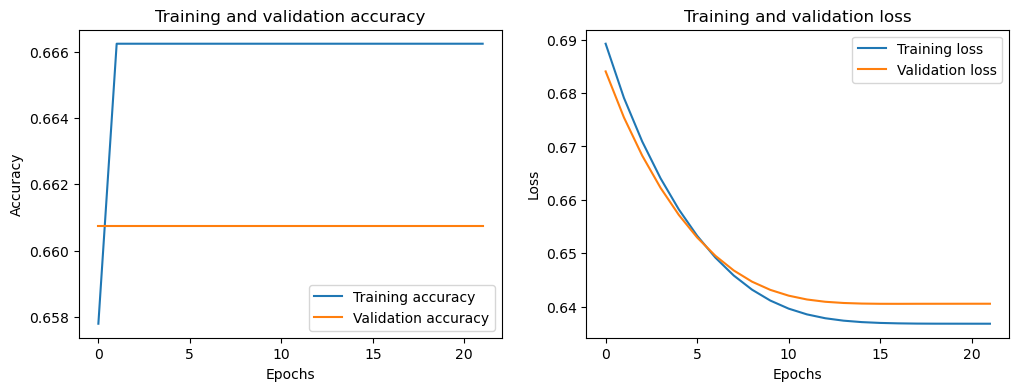

Evaluating the model
1077/1077 [==============================] - 55s 51ms/step - loss: 0.6382 - accuracy: 0.6643
Test accuracy:  0.6642674803733826


In [6]:
# Assuming `simple_cnn` and `SiameseTrainer` are defined as before
print("Creating the SiameseTrainer")
siamese_network = SiameseTrainer(base_model_func=new_model, input_shape=(96, 96, 1), num_classes=num_classes)
# siamese_network = SiameseTrainer(base_model_func=new_model, input_shape=(96, 96, 1), num_classes=num_classes)

# Set the optimizer
initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.96,
#     staircase=True)

optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
print("Compiling the model")
# siamese_network.compile_model(optimizer='adam', loss='binary_crossentropy')
siamese_network.compile_model(optimizer=optimizer, loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode = 'min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode = 'min')

# Train the model
print("Training the model")
# siamese_network.train_model(train_pairs, train_labels, val_pairs, val_labels, epochs=10, batch_size=32)
siamese_network.train_model(train_pairs, train_labels, val_pairs, val_labels, epochs=100, batch_size=128, model_save_name='Siam_model_mstar.h5',
                            callbacks=[early_stopping, reduce_lr])


# Plot training history
print("Plotting the training history")
siamese_network.plot_training()

# Evaluate the model
print("Evaluating the model")
siamese_network.evaluate_model(test_pairs, test_labels)
